# Taxi Demand Prediction in NYC *by Yuting Lu & Yilan Fan*

In [1]:
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
import gpxpy.geo
from datetime import datetime
import time
import seaborn as sns
import os
import math
import xgboost as xgb
import matplotlib
matplotlib.use('nbagg')
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.cluster import MiniBatchKMeans, KMeans
import warnings
#warnings.simplefilter('ignore')

In [2]:
data_2010_01 = dd.read_csv('yellow_tripdata_2010-01.csv',low_memory=False) 

In [3]:
data_2010_01.head()

vendor_id      pickup_datetime     dropoff_datetime  passenger_count  \
0       VTS  2010-01-26 07:41:00  2010-01-26 07:45:00                1   
1       DDS  2010-01-30 23:31:00  2010-01-30 23:46:12                1   
2       DDS  2010-01-18 20:22:20  2010-01-18 20:38:12                1   
3       VTS  2010-01-09 01:18:00  2010-01-09 01:35:00                2   
4       CMT  2010-01-18 19:10:14  2010-01-18 19:17:07                1   

   trip_distance  pickup_longitude  pickup_latitude  rate_code  \
0           0.75        -73.956778        40.767750          1   
1           5.90        -73.996118        40.763932          1   
2           4.00        -73.979673        40.783790          1   
3           4.70        -73.977922        40.763997          1   
4           0.60        -73.990924        40.734682          1   

   store_and_fwd_flag  dropoff_longitude  dropoff_latitude payment_type  \
0                 NaN         -73.965957         40.765232          CAS   
1                 NaN         -73.981512         40.741193          CAS   
2                 NaN         -73.917852         40.878560          CAS   
3                 NaN         -73.923908         40.759725          CAS   
4                 0.0         -73.995511         40.739088          Cre   

   fare_amount  surcharge  mta_tax  tip_amount  tolls_amount  total_amount  
0          4.5        0.0      0.5        0.00           0.0          5.00  
1         15.3        0.5      0.5        0.00           0.0         16.30  
2         11.7        0.5      0.5        0.00           0.0         12.70  
3         13.3        0.5      0.5        0.00           0.0         14.30  
4          5.3        0.0      0.5        0.87           0.0          6.67

In [71]:
data_2010_01.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 18 entries, vendor_id to total_amount
dtypes: object(4), float64(12), int64(2)

In [72]:
data_2010_01.columns

Index(['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'trip_distance', 'pickup_longitude', 'pickup_latitude', 'rate_code',
       'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude',
       'payment_type', 'fare_amount', 'surcharge', 'mta_tax', 'tip_amount',
       'tolls_amount', 'total_amount'],
      dtype='object')

### Creating new Dataframe with Trip duration and speed

In [4]:
def timeToUnix(t):
    #we have a time in the format "YYYY-MM-DD HH:MM:SS", which is a string
    change = datetime.strptime(t, "%Y-%m-%d %H:%M:%S") #this will convert the String time into datetime format
    t_tuple = change.timetuple() #this will convert the datetime formatted time into structured time
    return time.mktime(t_tuple) + 3600*8  #this will convert structured time into unix-time.
    #NOW, UNIX TIMESTAMP MEANS HOW MANY SECONDS HAVE ELAPSED SINCE 1 JAN 1970
    #(EPOCH) CALCULATED FROM THE REFERENCE OF GMT. I HAVE MADE THIS PROJECT IN CHINA WHICH IS 8HR/3600*8SECS AHEAD OF GMT TIME, 
    #AND HERE "time.mktime()" FUNCTION RETURNS UNIX TIMESTAMP FROM THE REFERENCE OF LOCAL TIME. SO, THEREFORE, IN ORDER TO 
    #COMPENSATE FOR 1HR AHEAD, "time.mktime" SUBTRACTED 3600 SECONDS MEANS 1HR FROM UNIX TIME STAMP IN ORDER TO CATER TO 
    #LOCAL TIME. SO, THEREFORE, IF WE WANT OUR UNIX TIME TO BE EXACTLY EQUAL TO GMT TIME, WE HAVE TO ADD 3600*8 SECONDS 
    #MEANS 1HR TO UNIX TIME. lET SAY AT 12:00AM ON 1st JAN 1970, TIME ELAPSED AT GMT IS 0, THE TIME ELAPSED IN China IS 
    #3600*8SEC. NOW ON 1st JAN 2010, ELASPED SECONDS AT GMT IS 'X', SO THE EQUIVALENT ELAPSED SECONDS IN China WILL BE X+3600*8. 
    #NOW "time.mktime()" SUBTRACT THIS 3600*8 EXTRA IN GERMAN TIME WHICH WE HAVE TO ADD IN ORDER TO MAKE IT EQUAL TO GMT.

def dfWithTripTimes(df):
    startTime = datetime.now()
    duration = df[["pickup_datetime", "dropoff_datetime"]] .compute()
    pickup_time = [timeToUnix(pkup) for pkup in duration["pickup_datetime"].values]
    dropoff_time = [timeToUnix(drpof) for drpof in duration["dropoff_datetime"].values]

    trip_duration = (np.array(dropoff_time) - np.array(pickup_time))/float(60)  #trip duration in minutes
    
    NewFrame = df[['passenger_count','trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','total_amount']] .compute()
    NewFrame["trip_duration"] = trip_duration
    NewFrame["pickup_time"] = pickup_time
    NewFrame["speed"] = (NewFrame["trip_distance"]/NewFrame["trip_duration"])*60  #speed in miles/hr
    
    print("Time taken for creation of dataframe is {}".format(datetime.now() - startTime))
    return NewFrame

In [5]:
new_frame = dfWithTripTimes(data_2010_01)

Time taken for creation of dataframe is 0:08:47.474817


In [6]:
new_frame

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                     1           0.75        -73.956778        40.767750   
1                     1           5.90        -73.996118        40.763932   
2                     1           4.00        -73.979673        40.783790   
3                     2           4.70        -73.977922        40.763997   
4                     1           0.60        -73.990924        40.734682   
...                 ...            ...               ...              ...   
277426                2           1.50        -73.970436        40.757928   
277427                1          16.77        -73.784115        40.648632   
277428                1           0.90        -74.002170        40.721619   
277429                1           2.00        -73.980066        40.770469   
277430                1           1.00        -73.979463        40.739982   

        dropoff_longitude  dropoff_latitude  total_amount  trip_duration  \
0              -73.965957         40.765232          5.00       4.000000   
1              -73.981512         40.741193         16.30      15.200000   
2              -73.917852         40.878560         12.70      15.866667   
3              -73.923908         40.759725         14.30      17.000000   
4              -73.995511         40.739088          6.67       6.883333   
...                   ...               ...           ...            ...   
277426         -73.957113         40.764094          8.20      11.666667   
277427         -73.974673         40.750805         45.50      23.000000   
277428         -73.988528         40.721484          8.60      13.816667   
277429         -73.958075         40.783242          7.80       7.300000   
277430         -73.994477         40.739006          6.60       7.916667   

         pickup_time      speed  
0       1.264492e+09  11.250000  
1       1.264894e+09  23.289474  
2       1.263846e+09  15.126050  
3       1.263000e+09  16.588235  
4       1.263842e+09   5.230024  
...              ...        ...  
277426  1.262789e+09   7.714286  
277427  1.263042e+09  43.747826  
277428  1.263046e+09   3.908323  
277429  1.263031e+09  16.438356  
277430  1.262705e+09   7.578947  

[14863778 rows x 10 columns]

## Data Cleaning 

###  Remove Pickups outside NYC

In [7]:
new_frame_cleaned = new_frame[(((new_frame.pickup_latitude >= 40.5774) & (new_frame.pickup_latitude <= 40.9176)) & ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_longitude <= -73.7004)))]

In [8]:
m = folium.Map(location = [40.9176, -73.7004], tiles = "Stamen Toner")

pickups_within_NYC = new_frame_cleaned.sample(n = 500)

for i,j in pickups_within_NYC.iterrows():
    folium.Marker([j["pickup_latitude"], j["pickup_longitude"]]).add_to(m)
m

### Remove Dropouts outside NYC 

In [9]:
new_frame_cleaned = new_frame_cleaned[(((new_frame_cleaned.dropoff_latitude >= 40.5774) & (new_frame_cleaned.dropoff_latitude <= 40.9176)) & ((new_frame_cleaned.dropoff_longitude >= -74.15) & (new_frame_cleaned.dropoff_longitude <= -73.7004)))]

In [10]:
m = folium.Map(location = [40.9176, -73.7004], tiles = "Stamen Toner")

dropoff_within_NYC = new_frame_cleaned.sample(n = 500)

for i,j in dropoff_within_NYC.iterrows():
    folium.Marker([j["dropoff_latitude"], j["dropoff_longitude"]]).add_to(m)
m

In [11]:
print("Fraction of cleaned points",str(new_frame_cleaned.shape[0]/new_frame.shape[0]))

Fraction of cleaned points 0.979191629476705


In [12]:
print("Total number of outliers and erroneous points removed = ",str(new_frame.shape[0] - new_frame_cleaned.shape[0]))

Total number of outliers and erroneous points removed =  309291


## Data Preparation

### Clustering 

In [13]:
coord = new_frame_cleaned[["pickup_latitude", "pickup_longitude"]].values
neighbors = []

def min_distance(regionCenters, totalClusters):
    good_points = 0
    bad_points = 0
    less_dist = []
    more_dist = []
    min_distance = 100000  #any big number can be given here
    for i in range(totalClusters):
        good_points = 0
        bad_points = 0
        for j in range(totalClusters):
            if j != i:
                distance = gpxpy.geo.haversine_distance(latitude_1 = regionCenters[i][0], longitude_1 = regionCenters[i][1], latitude_2 = regionCenters[j][0], longitude_2 = regionCenters[j][1])
                #you can check the documentation of above "gpxpy.geo.haversine_distance" at "https://github.com/tkrajina/gpxpy/blob/master/gpxpy/geo.py"
                #"gpxpy.geo.haversine_distance" gives distance between two latitudes and longitudes in meters. So, we have to convert it into miles.
                distance = distance/(1.60934*1000)   #distance from meters to miles
                min_distance = min(min_distance, distance) #it will return minimum of "min_distance, distance".
                if distance < 2:
                    good_points += 1
                else:
                    bad_points += 1
        less_dist.append(good_points)
        more_dist.append(bad_points)
    print("On choosing a cluster size of {}".format(totalClusters))
    print("Avg. Number clusters within vicinity where inter cluster distance < 2 miles is {}".format(np.ceil(sum(less_dist)/len(less_dist))))
    print("Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is {}".format(np.ceil(sum(more_dist)/len(more_dist))))
    print("Minimum distance between any two clusters = {}".format(min_distance))
    print("-"*10)
            
def makingRegions(noOfRegions):
    regions = MiniBatchKMeans(n_clusters = noOfRegions, batch_size = 10000).fit(coord)
    regionCenters = regions.cluster_centers_ 
    totalClusters = len(regionCenters)
    return regionCenters, totalClusters

In [14]:
startTime = datetime.now()
for i in range(10, 100, 10):
    regionCenters, totalClusters = makingRegions(i)
    min_distance(regionCenters, totalClusters)
print("Time taken = "+str(datetime.now() - startTime))

On choosing a cluster size of 10
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 2.0
Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is 8.0
Minimum distance between any two clusters = 0.9557743155028037
----------
On choosing a cluster size of 20
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 3.0
Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is 17.0
Minimum distance between any two clusters = 0.735664501528859
----------
On choosing a cluster size of 30
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 6.0
Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is 24.0
Minimum distance between any two clusters = 0.5384095450486877
----------
On choosing a cluster size of 40
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 8.0
Avg. Number clusters outside of vicinity where inter

In [15]:
coord = new_frame_cleaned[["pickup_latitude", "pickup_longitude"]].values
regions = MiniBatchKMeans(n_clusters = 30, batch_size = 10000).fit(coord)
new_frame_cleaned["pickup_cluster"] = regions.predict(new_frame_cleaned[["pickup_latitude", "pickup_longitude"]])

In [16]:
new_frame_cleaned.head()

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                1           0.75        -73.956778        40.767750   
1                1           5.90        -73.996118        40.763932   
2                1           4.00        -73.979673        40.783790   
3                2           4.70        -73.977922        40.763997   
4                1           0.60        -73.990924        40.734682   

   dropoff_longitude  dropoff_latitude  total_amount  trip_duration  \
0         -73.965957         40.765232          5.00       4.000000   
1         -73.981512         40.741193         16.30      15.200000   
2         -73.917852         40.878560         12.70      15.866667   
3         -73.923908         40.759725         14.30      17.000000   
4         -73.995511         40.739088          6.67       6.883333   

    pickup_time      speed  pickup_cluster  
0  1.264492e+09  11.250000               2  
1  1.264894e+09  23.289474              24  
2  1.263846e+09  15.126050              13  
3  1.263000e+09  16.588235              16  
4  1.263842e+09   5.230024              20

#### Plotting cluster centers 

In [17]:
centerOfRegions = regions.cluster_centers_
noOfClusters = len(centerOfRegions)
m = folium.Map(location = [40.9176, -73.7004], tiles = "Stamen Toner")

for i in range(noOfClusters):
    folium.Marker([centerOfRegions[i][0], centerOfRegions[i][1]], popup = (str(np.round(centerOfRegions[i][0], 2))+", "+str(np.round(centerOfRegions[i][1], 2)))).add_to(m)
m

#### Plotting Regions in NYC 

<IPython.core.display.Javascript object>


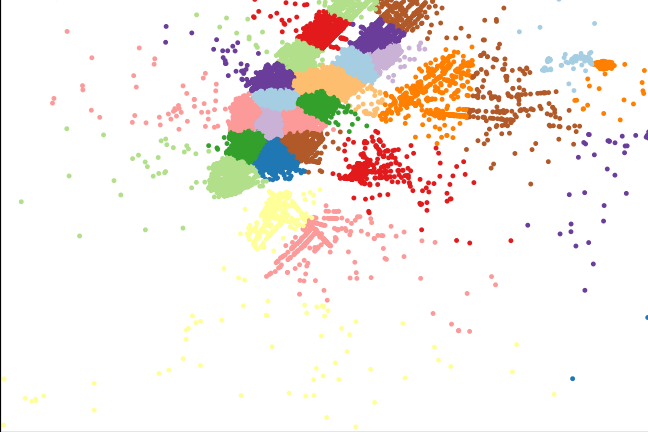

In [18]:
NYC_latitude_range = (40.5774, 40.9176)
NYC_Longitude_range = (-74.15, -73.7004)
fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
ax.scatter(x = new_frame_cleaned.pickup_longitude.values[:70000], y = new_frame_cleaned.pickup_latitude.values[:70000], c = new_frame_cleaned.pickup_cluster.values[:70000], cmap = "Paired", s = 5)
ax.set_xlim(-74.10, -73.72)
ax.set_ylim(40.5774, 40.9176)
ax.set_title("Regions in New York City")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()
#Longitude values vary from left to right i.e., horizontally
#Latitude values vary from top to bottom means i.e., vertically

### Time Binning 

In [19]:
new_frame_cleaned

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                     1           0.75        -73.956778        40.767750   
1                     1           5.90        -73.996118        40.763932   
2                     1           4.00        -73.979673        40.783790   
3                     2           4.70        -73.977922        40.763997   
4                     1           0.60        -73.990924        40.734682   
...                 ...            ...               ...              ...   
277426                2           1.50        -73.970436        40.757928   
277427                1          16.77        -73.784115        40.648632   
277428                1           0.90        -74.002170        40.721619   
277429                1           2.00        -73.980066        40.770469   
277430                1           1.00        -73.979463        40.739982   

        dropoff_longitude  dropoff_latitude  total_amount  trip_duration  \
0              -73.965957         40.765232          5.00       4.000000   
1              -73.981512         40.741193         16.30      15.200000   
2              -73.917852         40.878560         12.70      15.866667   
3              -73.923908         40.759725         14.30      17.000000   
4              -73.995511         40.739088          6.67       6.883333   
...                   ...               ...           ...            ...   
277426         -73.957113         40.764094          8.20      11.666667   
277427         -73.974673         40.750805         45.50      23.000000   
277428         -73.988528         40.721484          8.60      13.816667   
277429         -73.958075         40.783242          7.80       7.300000   
277430         -73.994477         40.739006          6.60       7.916667   

         pickup_time      speed  pickup_cluster  
0       1.264492e+09  11.250000               2  
1       1.264894e+09  23.289474              24  
2       1.263846e+09  15.126050              13  
3       1.263000e+09  16.588235              16  
4       1.263842e+09   5.230024              20  
...              ...        ...             ...  
277426  1.262789e+09   7.714286              15  
277427  1.263042e+09  43.747826               3  
277428  1.263046e+09   3.908323               9  
277429  1.263031e+09  16.438356               5  
277430  1.262705e+09   7.578947              11  

[14554487 rows x 11 columns]

In [20]:
# Unix Time Converter https://time.is/zh/Unix_time_converter 

In [21]:
# 1262275200 : 2010-01-01 00:00:00   (Equivalent unix time)
# 1293811200 : 2011-01-01 00:00:00   (Equivalent unix time)

def pickup_10min_bins(dataframe, month, year):
    pickupTime = dataframe["pickup_time"].values
    unixTime = [1262275200, 1293811200]
    unix_year = unixTime[year-2010]
    time_10min_bin = [int((i - unix_year)/600) for i in pickupTime]
    dataframe["time_bin"] = np.array(time_10min_bin)
    return dataframe

In [22]:
jan_2010_data = pickup_10min_bins(new_frame_cleaned, 1, 2010)

In [23]:
jan_2010_data.head()

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                1           0.75        -73.956778        40.767750   
1                1           5.90        -73.996118        40.763932   
2                1           4.00        -73.979673        40.783790   
3                2           4.70        -73.977922        40.763997   
4                1           0.60        -73.990924        40.734682   

   dropoff_longitude  dropoff_latitude  total_amount  trip_duration  \
0         -73.965957         40.765232          5.00       4.000000   
1         -73.981512         40.741193         16.30      15.200000   
2         -73.917852         40.878560         12.70      15.866667   
3         -73.923908         40.759725         14.30      17.000000   
4         -73.995511         40.739088          6.67       6.883333   

    pickup_time      speed  pickup_cluster  time_bin  
0  1.264492e+09  11.250000               2      3694  
1  1.264894e+09  23.289474              24      4365  
2  1.263846e+09  15.126050              13      2618  
3  1.263000e+09  16.588235              16      1207  
4  1.263842e+09   5.230024              20      2611

In [24]:
print("There should be ((24*60)/10)*31 unique 10 minute time bins for the month of January 2010: ", str(len(np.unique(jan_2010_data["time_bin"]))))

There should be ((24*60)/10)*31 unique 10 minute time bins for the month of January 2010:  4464


In [25]:
jan_2010_timeBin_groupBy = jan_2010_data[["pickup_cluster", "time_bin", "trip_distance"]].groupby(by = ["pickup_cluster", "time_bin"]).count()

In [26]:
jan_2010_timeBin_groupBy.head()

trip_distance
pickup_cluster time_bin               
0              48                  101
               49                  283
               50                  303
               51                  326
               52                  298

## Smoothing

In [27]:
def getUniqueBinsWithPickups(dataframe):
    values = []
    for i in range(30):          #we have total 30 clusters
        cluster_id = dataframe[dataframe["pickup_cluster"] == i]
        unique_clus_id = list(set(cluster_id["time_bin"]))
        unique_clus_id.sort()   #inplace sorting
        values.append(unique_clus_id)
    return values
#this function is returning the indices of all the unique time_bins where there is a pickup for all the 30 clusters.

In [28]:
#now for Jan-2010, we have to find out, how many time_bins are there where there is no pickup in any of the cluster region
unique_binswithPickup_Jan_2010 = getUniqueBinsWithPickups(jan_2010_data)
for i in range(30):             #we have total 30 clusters
    print("For cluster ID {}, total number of time bins with no pickup in this clutser region is {}".format(i, (4464 - len(unique_binswithPickup_Jan_2010[i]))))
    print("-"*90)
#there are total 4464 time bins in Jan - 2010.
#"unique_binswithPickup_Jan_2010" contains all the unique time bins, where pickup happened. It contains 30 sub-arrays as there are 30 clusters
#and each sub-array contains the unique ID of all the time bins where pickup happened in the clusters which is the index of that sub-array.

For cluster ID 0, total number of time bins with no pickup in this clutser region is 0
------------------------------------------------------------------------------------------
For cluster ID 1, total number of time bins with no pickup in this clutser region is 210
------------------------------------------------------------------------------------------
For cluster ID 2, total number of time bins with no pickup in this clutser region is 0
------------------------------------------------------------------------------------------
For cluster ID 3, total number of time bins with no pickup in this clutser region is 68
------------------------------------------------------------------------------------------
For cluster ID 4, total number of time bins with no pickup in this clutser region is 0
------------------------------------------------------------------------------------------
For cluster ID 5, total number of time bins with no pickup in this clutser region is 0
--------------------

In [29]:
def smoothing(numberOfPickups, correspondingTimeBin):
    ind = 0
    repeat = 0
    smoothed_region = []
    for cluster in range(0, 30):
        smoothed_bin = []
        for t1 in range(4464):
            if repeat != 0:   #this will ensure that we shall not fill the pickup values again which we already filled by smoothing
                repeat -= 1
            else:
                if t1 in correspondingTimeBin[cluster]:
                    smoothed_bin.append(numberOfPickups[ind])
                    ind += 1
                else:
                    if t1 == 0:           
    #<---------------------CASE-1:Pickups missing in the beginning------------------------>
                        for t2 in range(t1, 4464):
                            if t2 not in correspondingTimeBin[cluster]:
                                continue
                            else:
                                right_hand_limit = t2
                                smoothed_value = (numberOfPickups[ind]*1.0)/((right_hand_limit + 1)*1.0)
                                for i in range(right_hand_limit + 1):
                                    smoothed_bin.append(math.ceil(smoothed_value))
                                ind += 1
                                repeat = right_hand_limit - t1
                                
                    if t1 != 0:
                        right_hand_limit = 0
                        for t2 in range(t1, 4464):
                            if t2 not in correspondingTimeBin[cluster]:
                                continue
                            else:
                                right_hand_limit = t2
                                break
                        if right_hand_limit == 0:
    #<---------------------CASE-2: Pickups MISSING IN THE END------------------------------>
                            smoothed_value = (numberOfPickups[ind-1]*1.0)/(((4464 - t1)+1)*1.0)
                            del smoothed_bin[-1]
                            for i in range((4464 - t1)+1):
                                smoothed_bin.append(math.ceil(smoothed_value))
                            repeat = (4464 - t1) - 1    
    #<---------------------CASE-3: Pickups MISSING IN MIDDLE OF TWO VALUES----------------> 
                        else: 
                            smoothed_value = ((numberOfPickups[ind-1] + numberOfPickups[ind])*1.0)/(((right_hand_limit - t1)+2)*1.0)
                            del smoothed_bin[-1]
                            for i in range((right_hand_limit - t1)+2):
                                smoothed_bin.append(math.ceil(smoothed_value))
                            ind += 1
                            repeat = right_hand_limit - t1                        
        smoothed_region.extend(smoothed_bin)
    return smoothed_region

# when we multiply any integer with "1.0", then it will be converted into float.

In [30]:
# Fill the missing value with 0's.
def fillMissingWithZero(numberOfPickups, correspondingTimeBin):
    ind = 0
    smoothed_regions = []
    for c in range(0, 30):
        smoothed_bins = []
        for t in range(4464):    #there are total 4464 time bins in Jan 2010
            if t in correspondingTimeBin[c]:   #if a time bin is present in "correspondingTimeBin" in cluster 'c', 
            #then it means there is a pickup, in this case, we are simply adding number of pickups, else we are adding 0.
                smoothed_bins.append(numberOfPickups[ind])
                ind += 1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions
#above function performs the operation in this way: if in any cluster if there is no pickup in any of the 4464 time bins, then 
#it simply appends 0 in that missing time_bin else it adds the original number of pickups in that time_bins.

In [31]:
jan_2010_fillZero = fillMissingWithZero(jan_2010_timeBin_groupBy["trip_distance"].values, unique_binswithPickup_Jan_2010)
# here in jan_2010_timeBin_groupBy dataframe the "trip_distance" represents the number of pickups that are happened.
jan_2010_fillSmooth = smoothing(jan_2010_timeBin_groupBy["trip_distance"].values, unique_binswithPickup_Jan_2010)

#"unique_binswithPickup_Jan_2010" contains all the unique time bins, where pickup happened. It contains 30 sub-arrays as there are 30 clusters
#and each sub-array contains the unique ID of all the time bins where pickup happened in the clusters which is the index of that sub-array.

In [32]:
def countZeros(num):
    count = 0
    for i in num:
        if i == 0:
            count += 1
    return count

In [33]:
print("Sanity check for number of zeros in smoothed data = "+str(countZeros(jan_2010_fillSmooth)))

Sanity check for number of zeros in smoothed data = 0


In [34]:
print(len(jan_2010_fillSmooth))

296321483


In [35]:
unique_binswithPickup_Jan_2010 = getUniqueBinsWithPickups(jan_2010_data)

In [36]:
jan_2010_fillZero = fillMissingWithZero(jan_2010_timeBin_groupBy["trip_distance"].values, unique_binswithPickup_Jan_2010)

In [37]:
regionWisePickup_Jan_2010 = []
for i in range(30):
    regionWisePickup_Jan_2010.append(jan_2010_fillZero[4464*i:((4464*i)+4464)])
#"regionWisePickup_Jan_2010" is a list of lists which contains 30 sub lists, where the index of each sub-list is the 
#corresponding cluster number and the element of each sub-list is the pickup value. So, we know that there are 4464 time bins 
#in Jan 2010, hence, each sub-list is of size 4464.

In [38]:
print(len(regionWisePickup_Jan_2010))
print(len(regionWisePickup_Jan_2010[0]))

30
4464


## Regression Model 

In [39]:
# we take number of pickups that are happened in last 5 10min intravels
number_of_time_stamps = 5

# TruePickups varaible
# it is list of lists
# It will be used as true labels/ground truth. Now since we are taking previous 5 pickups as a training data for predicting
# next pickup(here next pickup will be a true/ground truth pickup), so "TruePickups" will not contain first five pickups of each 
# cluster. It will contain number of pickups 4459 for each cluster. 
TruePickups = []


# lat will contain 4464-5=4459 times latitude of cluster center for every cluster.
# Ex: [[cent_lat 4459 times],[cent_lat 4459 times], [cent_lat 4459 times].... 30 lists]
# it is list of lists
lat = []


# lon will contain 4464-5=4459 times longitude of cluster center for every cluster.
# Ex: [[cent_lat 4459 times],[cent_lat 4459 times], [cent_lat 4459 times].... 30 lists]
# it is list of lists
lon = []

# we will code each day 
# sunday = 0, monday=1, tue = 2, wed=3, thur=4, fri=5,sat=6
day_of_week = []


# for every cluster we will be adding 4459 values, each value represent to which day of the week that pickup bin belongs to
# it is list of lists

# feat is a numbpy array, of shape (133770, 5). {4459*30 = 133770.}
# each row corresponds to an entry in our data
# for the first row we will have [f0,f1,f2,f3,f4] fi=number of pickups happened in i+1st 10min intravel(bin)
# the second row will have [f1,f2,f3,f4,f5]
# the third row will have [f2,f3,f4,f5,f6]
# and so on...
feat = []


centerOfRegions = regions.cluster_centers_
feat = [0]*number_of_time_stamps
for i in range(30):
    lat.append([centerOfRegions[i][0]]*4459) 
    lon.append([centerOfRegions[i][1]]*4459)

    day_of_week.append([int(((int(j/144)%7)+5)%7) for j in range(5, 4464)])

    feat = np.vstack((feat, [regionWisePickup_Jan_2010[i][k:k+number_of_time_stamps] for k in range(0, len(regionWisePickup_Jan_2010[i]) - (number_of_time_stamps))]))
    TruePickups.append(regionWisePickup_Jan_2010[i][5:])
    #output contains pickup values of all the regions and of each time stamp, except first 5 time stamp pickups of each region.
feat = feat[1:]

In [40]:
len(lat[0])*len(lat) == len(lon[0])*len(lon) == len(day_of_week[0])*len(day_of_week) == 4459*30 == len(feat) == len(TruePickups[0])*len(TruePickups)

True

In [41]:
feat

array([[  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0],
       ...,
       [206, 203, 204, 206, 195],
       [203, 204, 206, 195, 219],
       [204, 206, 195, 219, 227]], dtype=int64)

In [42]:
# "predicted_pickup_values": it is a temporary array that store weighted moving avarag prediction values for each 10min intervl, 
# for each cluster it will get reset.
# for every cluster it contains 4464 values
predicted_pickup_values = []


predicted_pickup_values_list = []

predicted_value = -1  

window_size = 2
for i in range(30):
    for j in range(4464):
        if j == 0:
            predicted_value = regionWisePickup_Jan_2010[i][j]
            predicted_pickup_values.append(0)
        else:
            if j>=window_size:
                sumPickups = 0
                sumOfWeights = 0
                for k in range(window_size, 0, -1):
                    sumPickups += k*(regionWisePickup_Jan_2010[i][j -window_size + (k - 1)])
                    sumOfWeights += k
                predicted_value = int(sumPickups/sumOfWeights)
                predicted_pickup_values.append(predicted_value)
            else:
                sumPickups = 0
                sumOfWeights = 0
                for k in range(j, 0, -1):
                    sumPickups += k*regionWisePickup_Jan_2010[i][k-1]
                    sumOfWeights += k
                predicted_value = int(sumPickups/sumOfWeights)
                predicted_pickup_values.append(predicted_value)
                
    predicted_pickup_values_list.append(predicted_pickup_values[5:])
    predicted_pickup_values = []

In [43]:
len(predicted_pickup_values_list[0])*len(predicted_pickup_values_list) == 4459*30

True

<IPython.core.display.Javascript object>


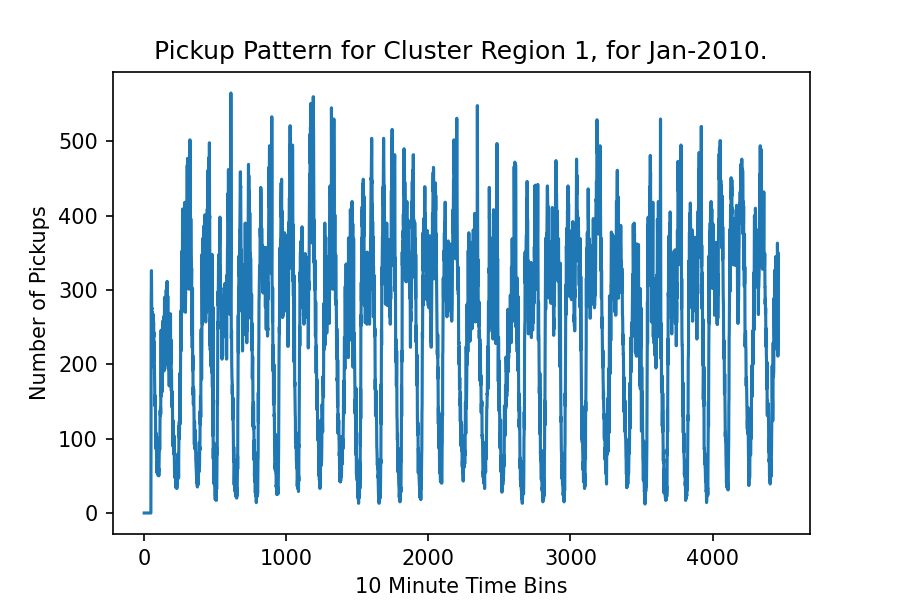

<IPython.core.display.Javascript object>


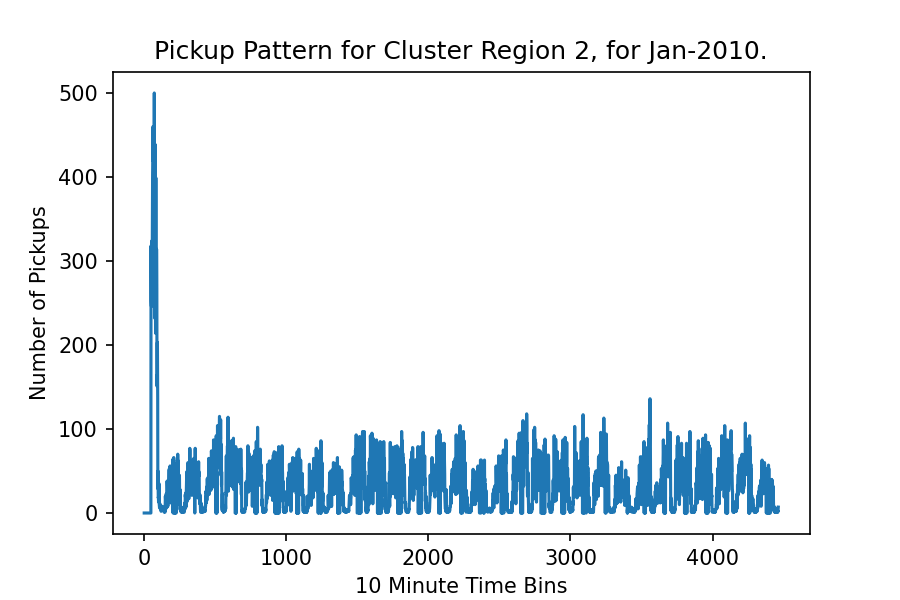

<IPython.core.display.Javascript object>


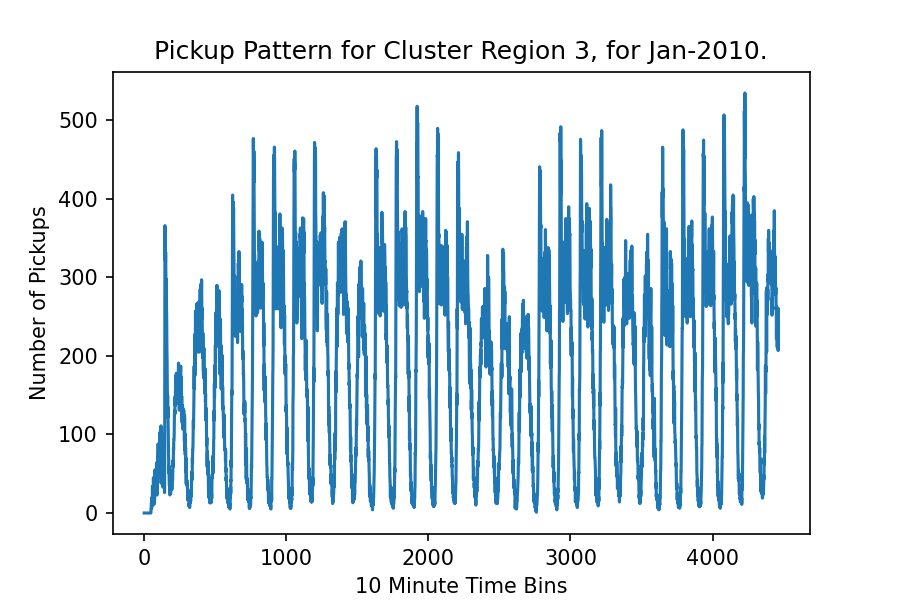

<IPython.core.display.Javascript object>


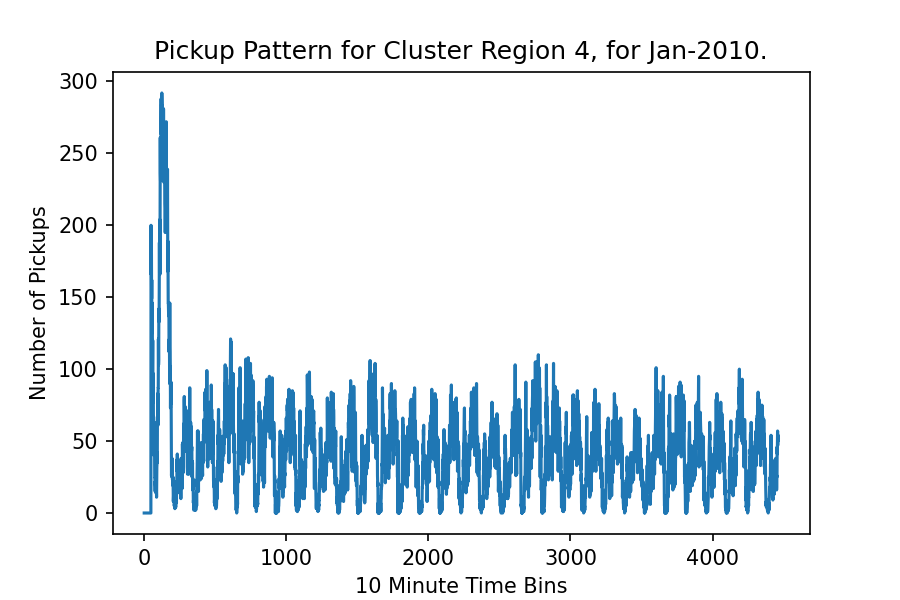

<IPython.core.display.Javascript object>


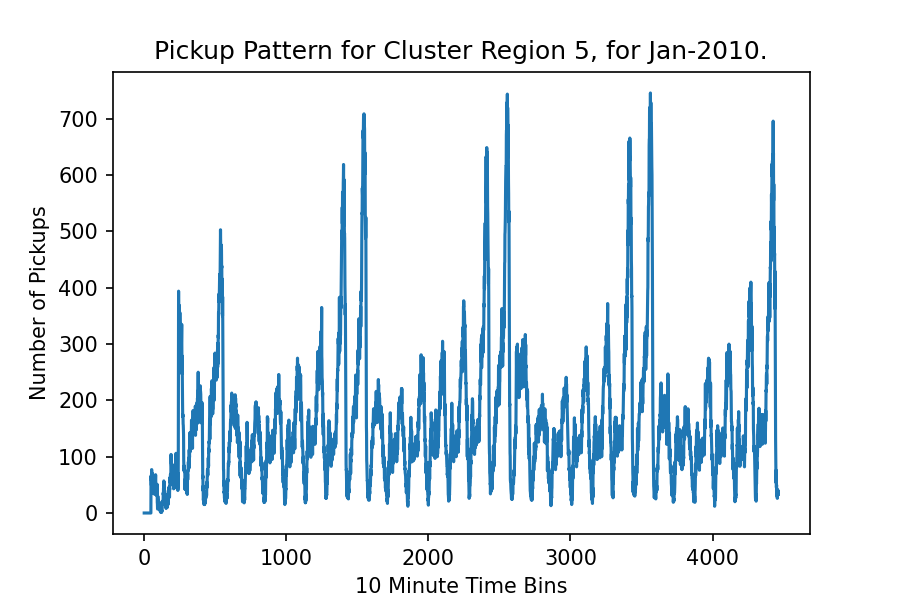

<IPython.core.display.Javascript object>


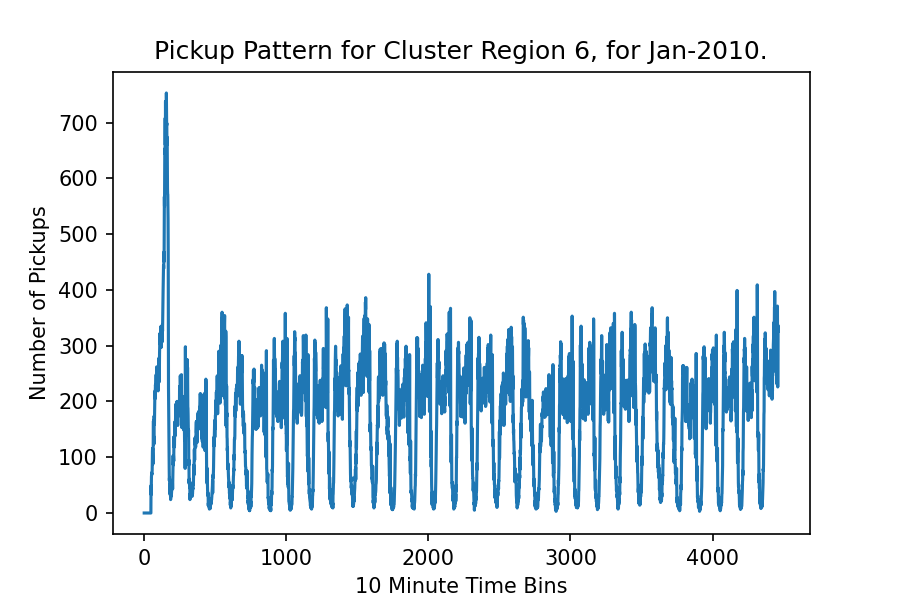

<IPython.core.display.Javascript object>


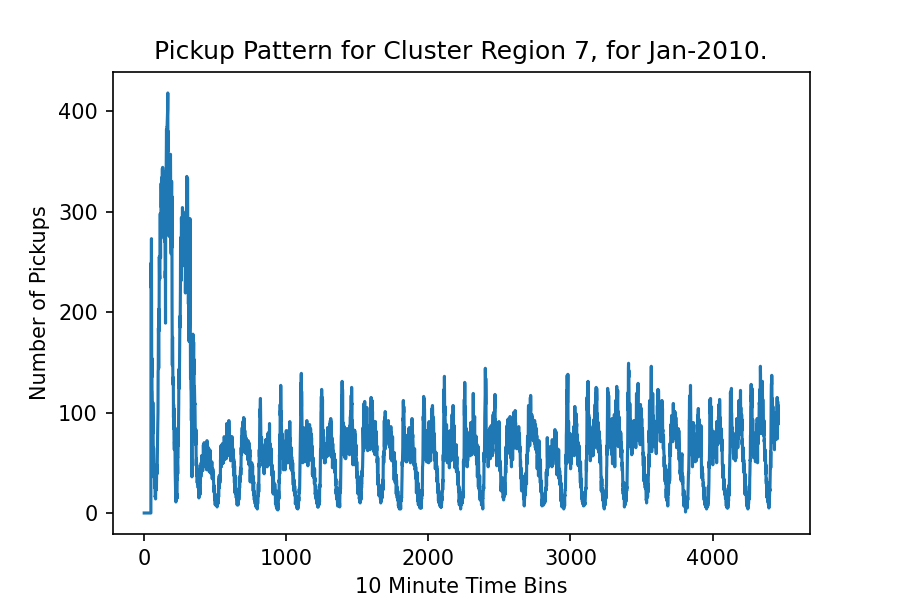

<IPython.core.display.Javascript object>


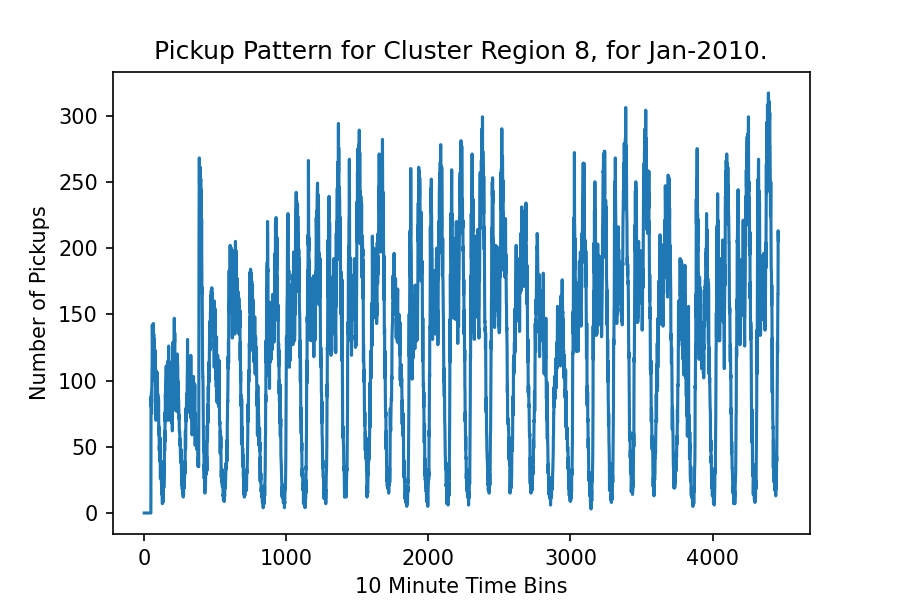

<IPython.core.display.Javascript object>


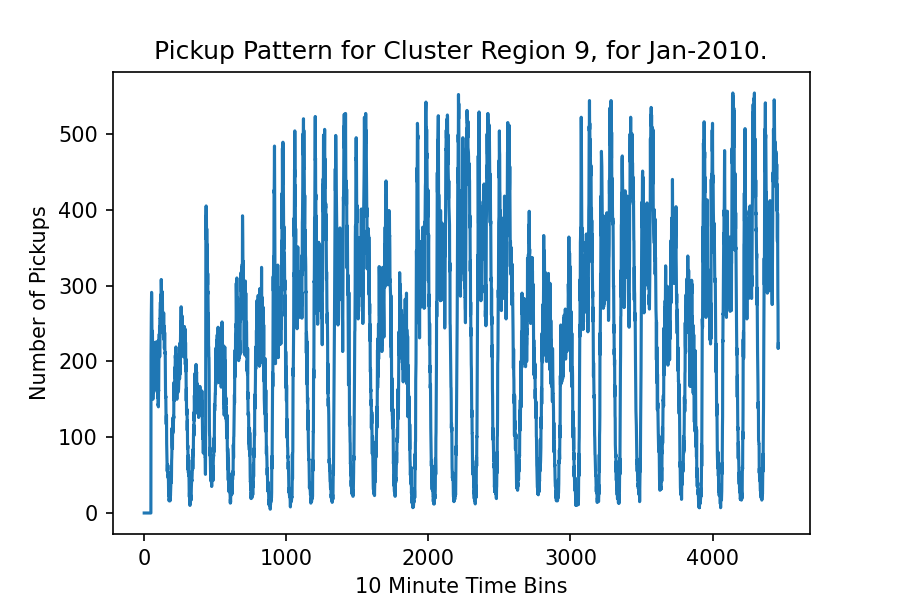

<IPython.core.display.Javascript object>


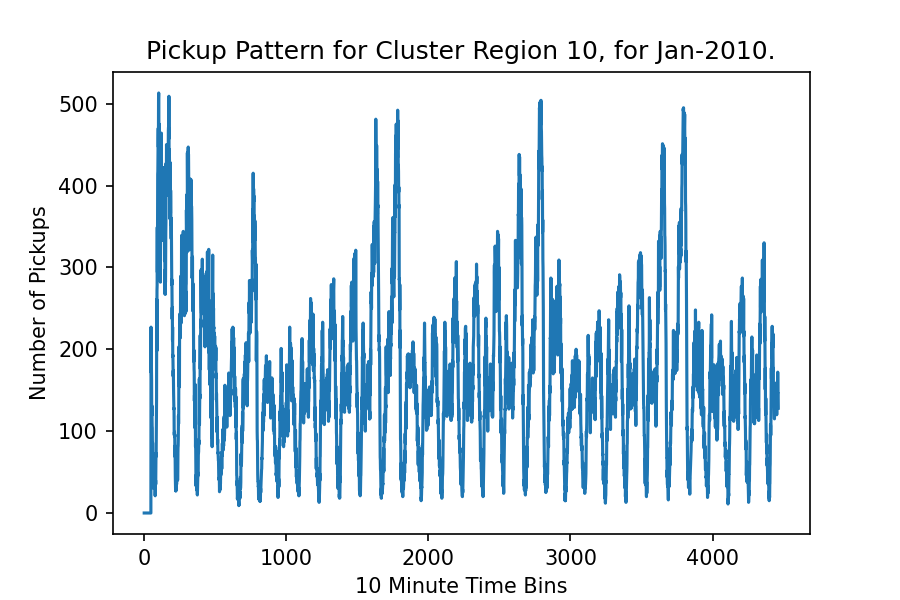

<IPython.core.display.Javascript object>


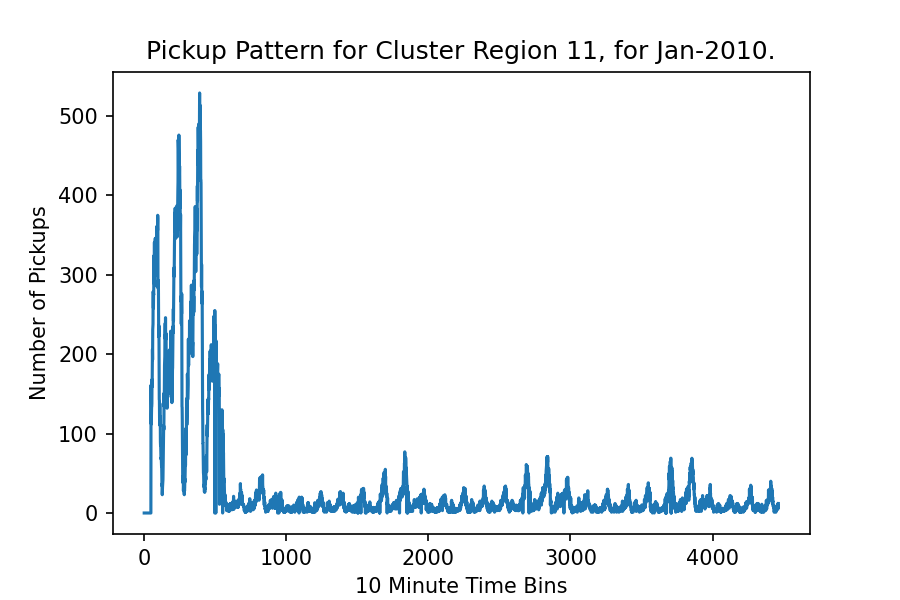

<IPython.core.display.Javascript object>


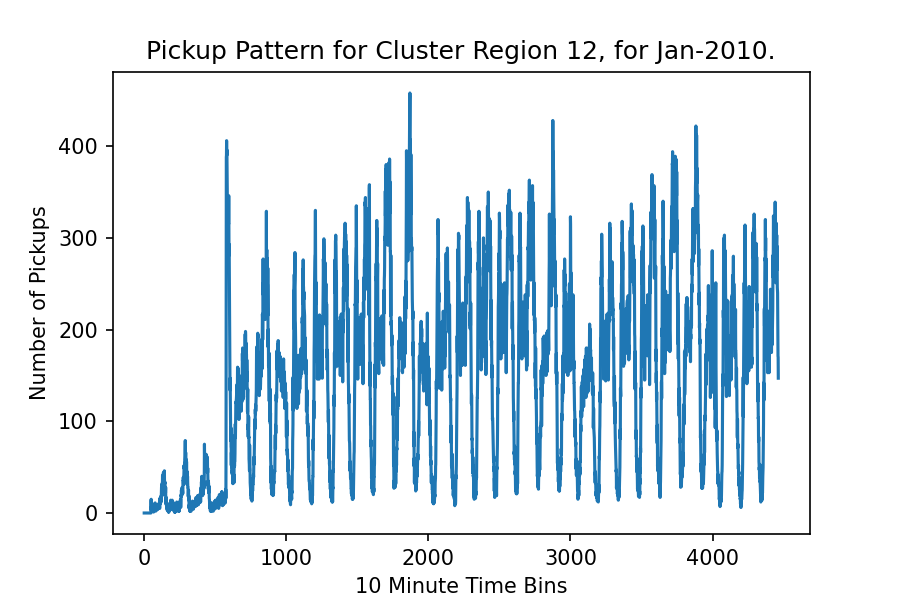

<IPython.core.display.Javascript object>


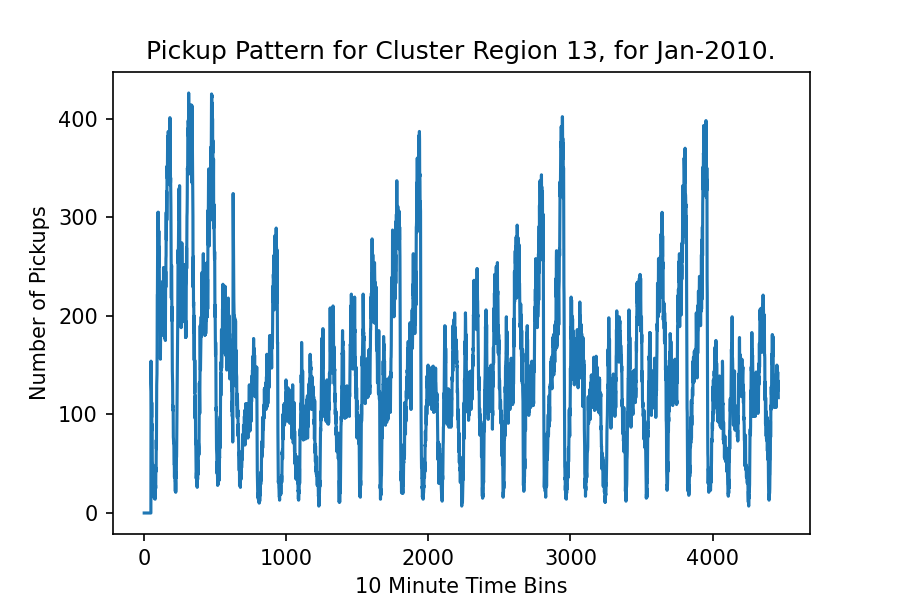

<IPython.core.display.Javascript object>


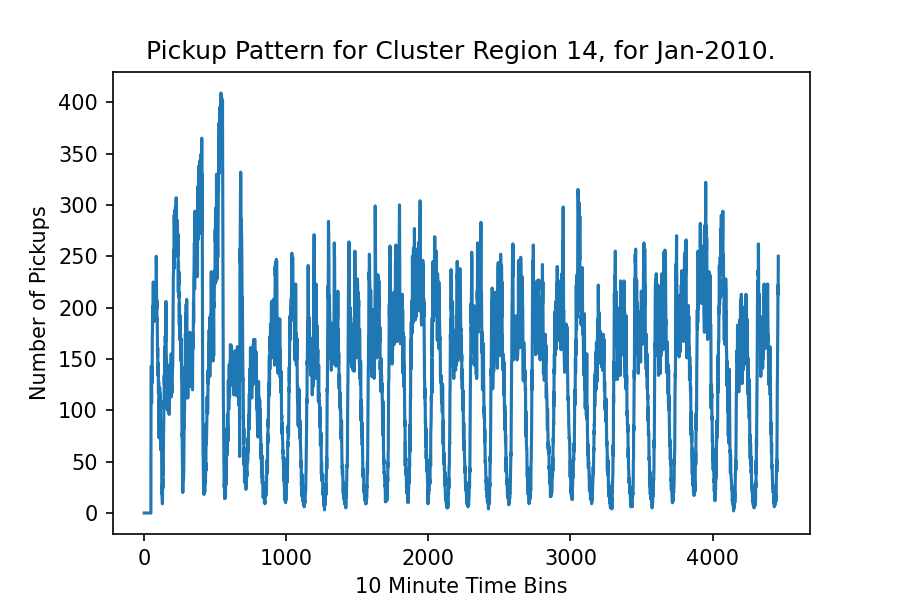

<IPython.core.display.Javascript object>


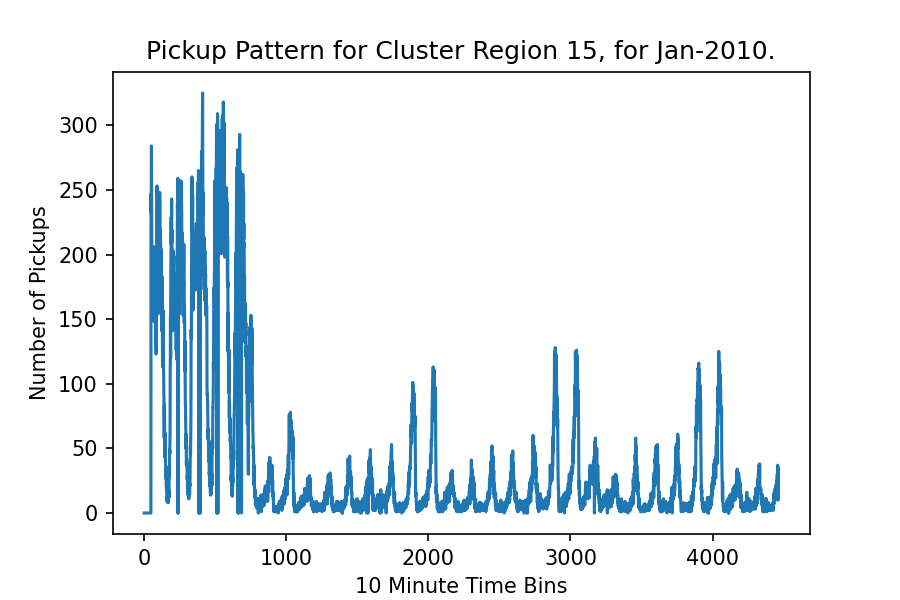

<IPython.core.display.Javascript object>


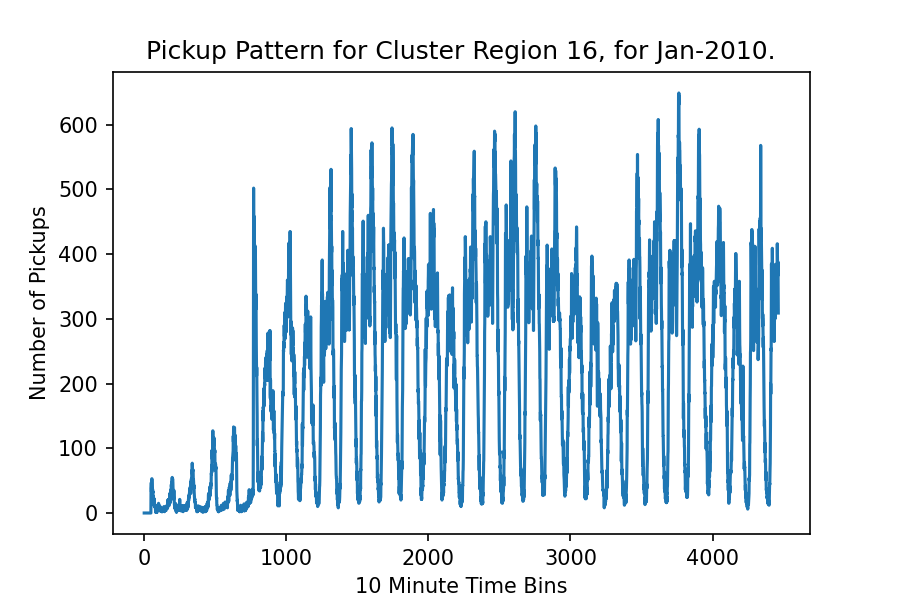

<IPython.core.display.Javascript object>


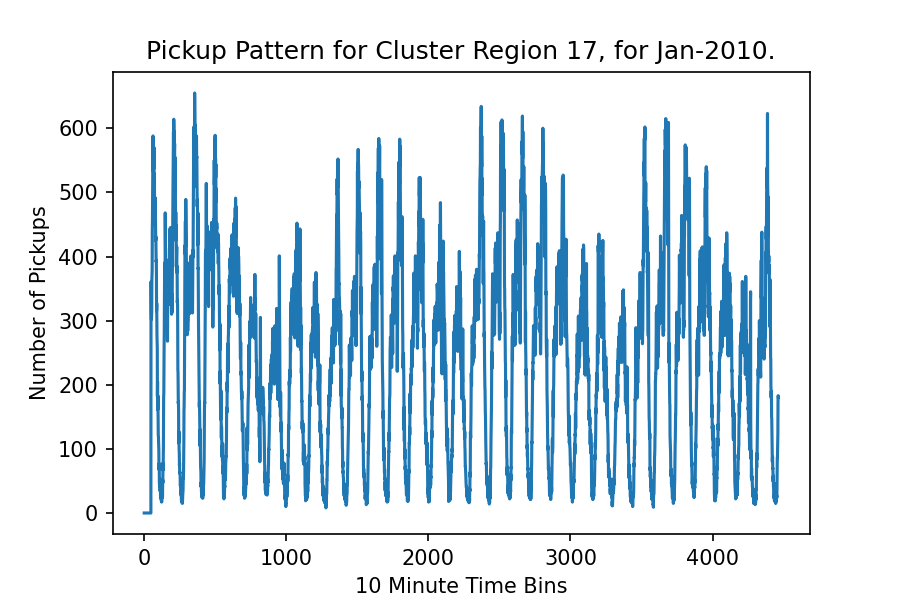

<IPython.core.display.Javascript object>


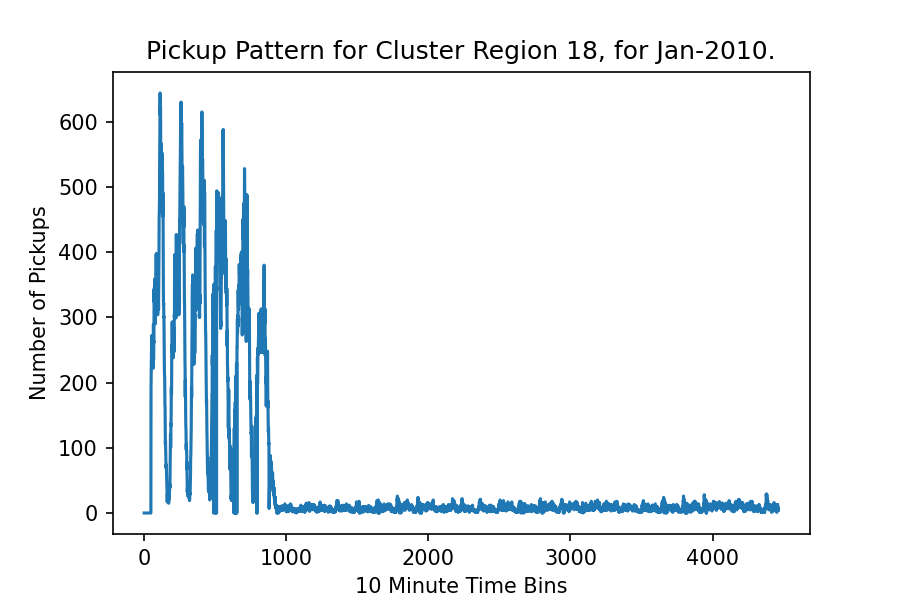

<IPython.core.display.Javascript object>


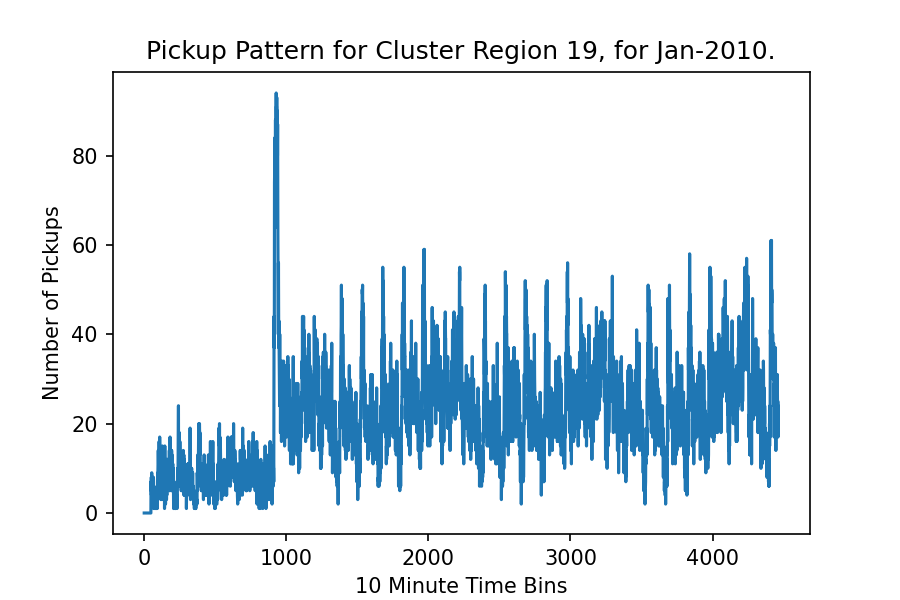

<IPython.core.display.Javascript object>


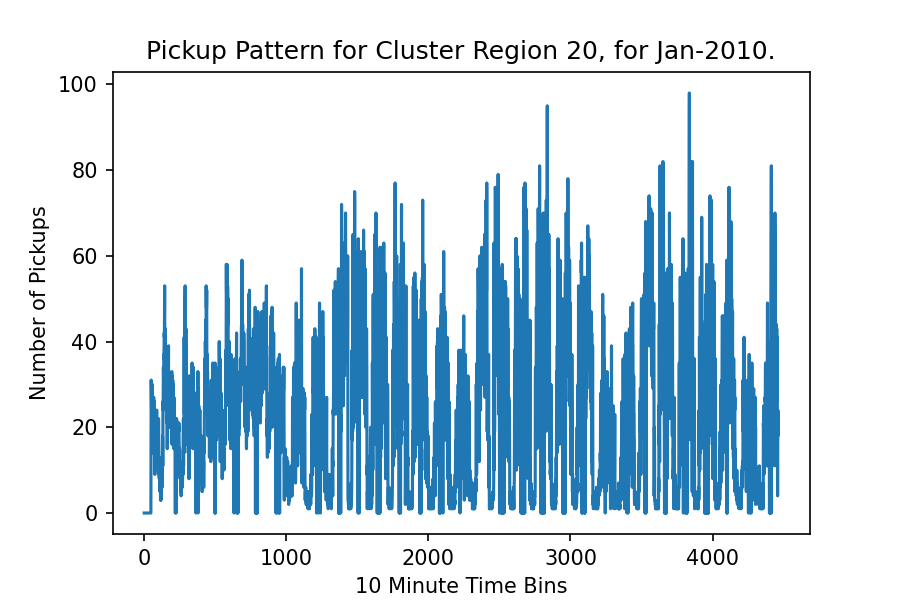

C:\Users\yutin\AppData\Local\Temp/ipykernel_1108/1559403929.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize = (6, 4))


<IPython.core.display.Javascript object>


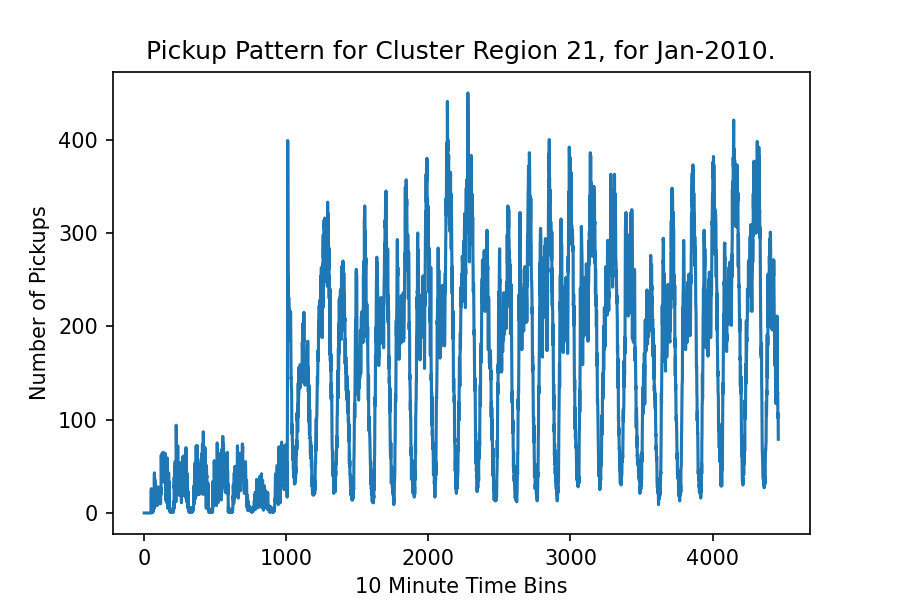

<IPython.core.display.Javascript object>


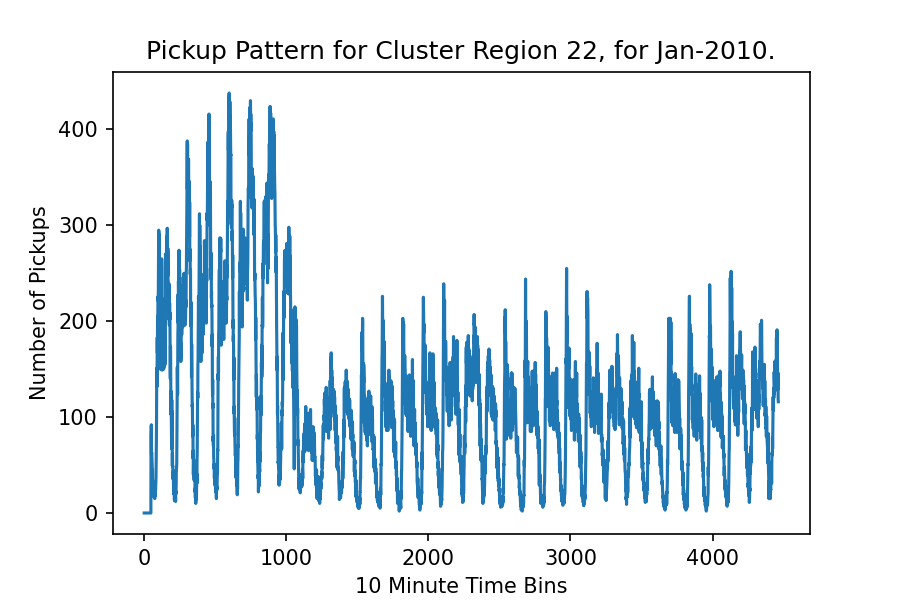

<IPython.core.display.Javascript object>


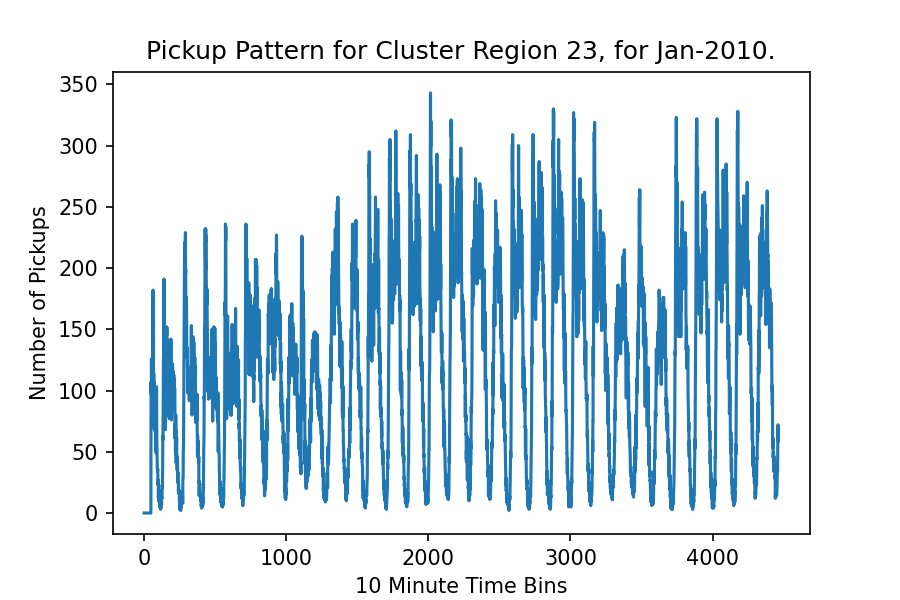

<IPython.core.display.Javascript object>


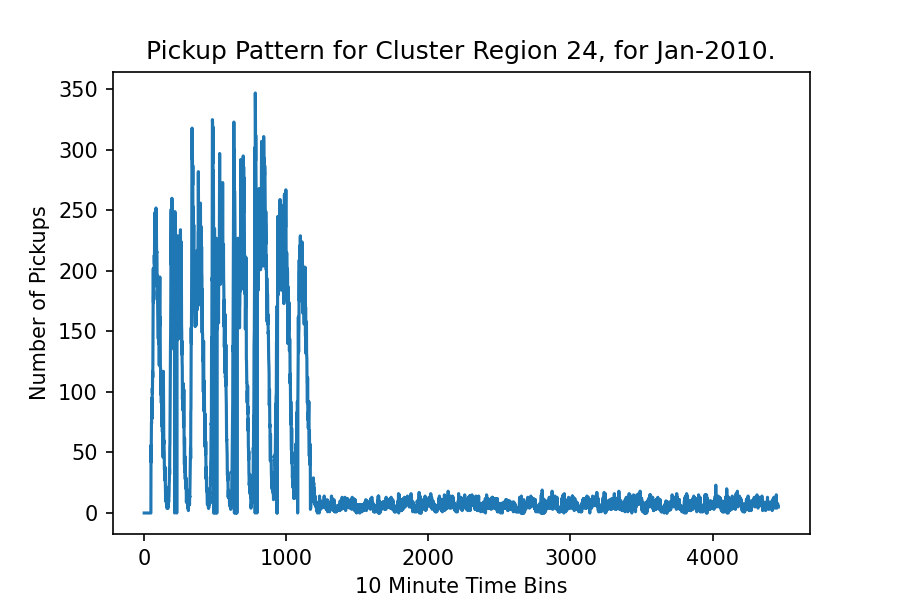

<IPython.core.display.Javascript object>


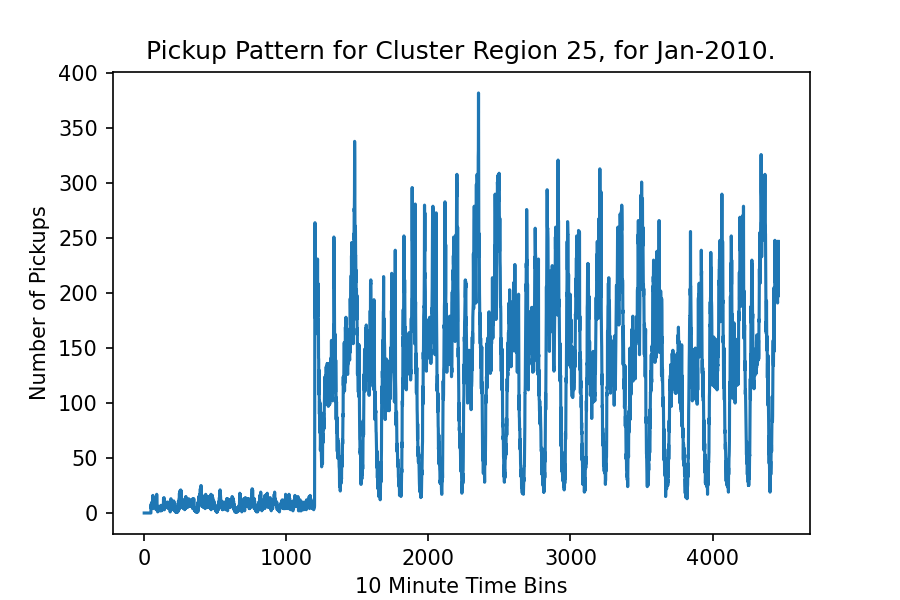

<IPython.core.display.Javascript object>


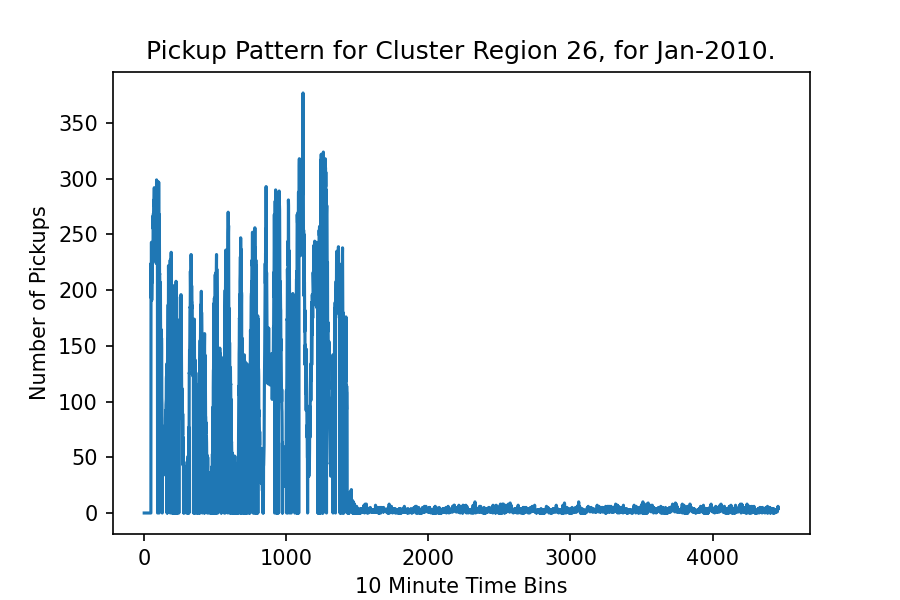

<IPython.core.display.Javascript object>


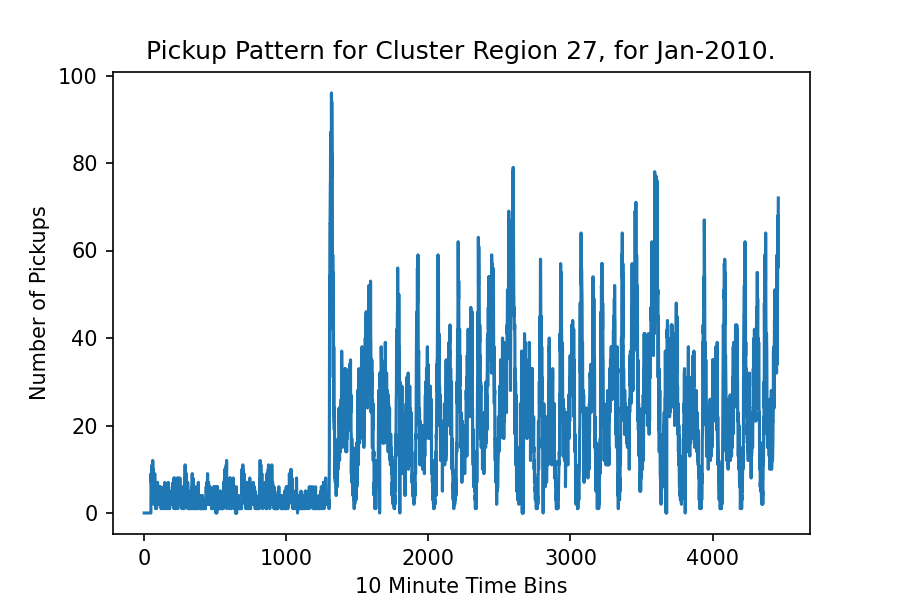

<IPython.core.display.Javascript object>


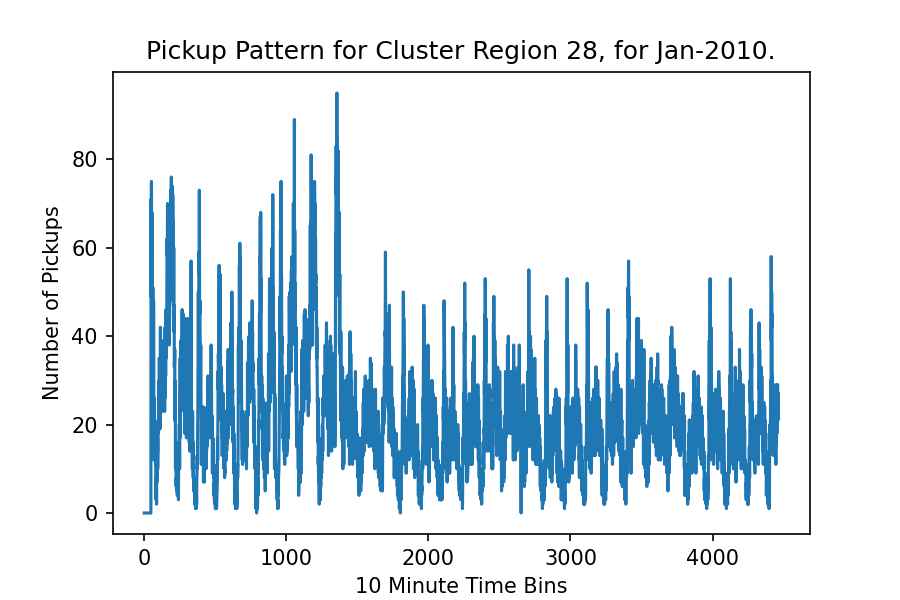

<IPython.core.display.Javascript object>


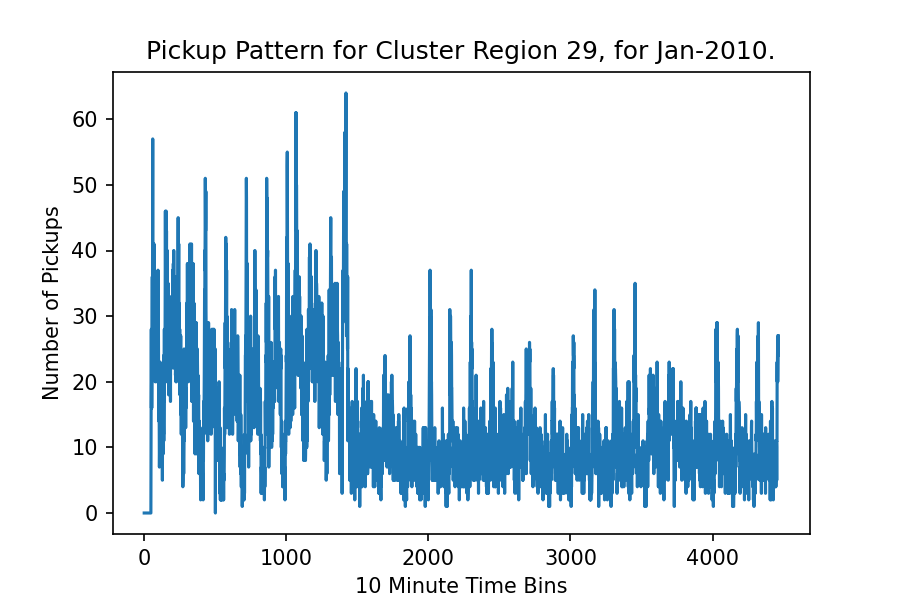

<IPython.core.display.Javascript object>


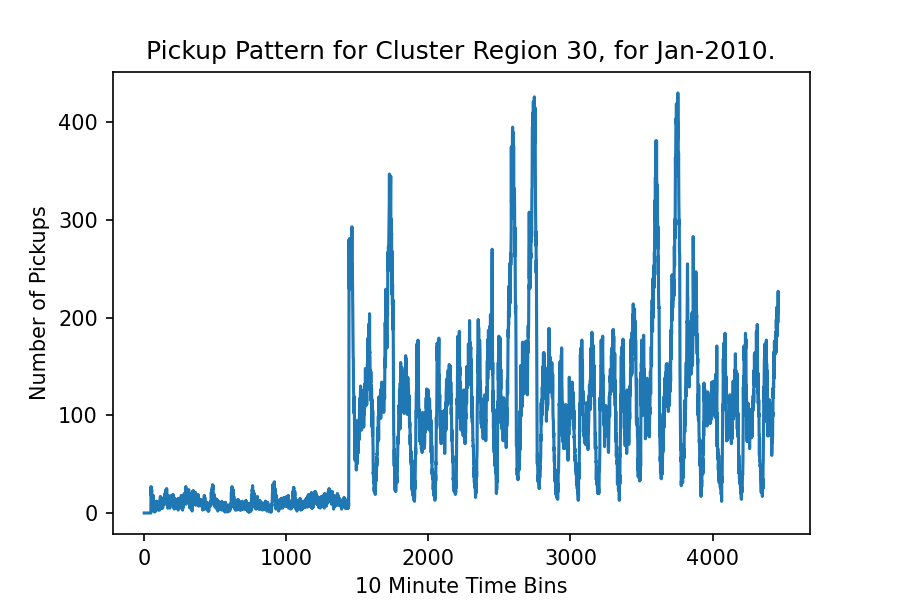

In [73]:
%matplotlib notebook
for i in range(30):
    fig = plt.figure(figsize = (6, 4))
    plt.plot(regionWisePickup_Jan_2010[i][:4464])
    plt.title("Pickup Pattern for Cluster Region "+str(i+1)+", for Jan-2010.")
    plt.xlabel("10 Minute Time Bins")
    plt.ylabel("Number of Pickups")

In [45]:
amplitude_lists = []
frequency_lists = []
for i in range(30):
    ampli  = np.abs(np.fft.fft(regionWisePickup_Jan_2010[i][0:4096]))
    freq = np.abs(np.fft.fftfreq(4096, 1))
    ampli_indices = np.argsort(-ampli)[1:]        #it will return an array of indices for which corresponding amplitude values are sorted in reverse order.
    amplitude_values = []
    frequency_values = []
    for j in range(0, 9, 2):   #taking top five amplitudes and frequencies
        amplitude_values.append(ampli[ampli_indices[j]])
        frequency_values.append(freq[ampli_indices[j]])
    for k in range(4459):    #those top 5 frequencies and amplitudes are same for all the points in one cluster
        amplitude_lists.append(amplitude_values)
        frequency_lists.append(frequency_values) 

## Data Preparation for regression models

In [46]:
print("size of total train data :" +str(int(133770*0.8)))
print("size of total test data :" +str(int(133770*0.2)))

size of total train data :107016
size of total test data :26754


In [47]:
print("size of train data for one cluster:" +str(int(4459*0.8)))
print("size of total test data for one cluster:" +str(int(4459*0.2)))

size of train data for one cluster:3567
size of total test data for one cluster:891


In [48]:
train_previousFive_pickups  = [feat[i*4459:(4459*i+3567)] for i in range(30)]
test_previousFive_pickups  = [feat[(i*4459)+3567:(4459*(i+1))] for i in range(30)]

In [49]:
train_fourier_frequencies = [frequency_lists[i*4459:(4459*i+3567)] for i in range(30)]
test_fourier_frequencies = [frequency_lists[(i*4459)+3567:(4459*(i+1))] for i in range(30)]

In [50]:
train_fourier_amplitudes = [amplitude_lists[i*4459:(4459*i+3567)] for i in range(30)]
test_fourier_amplitudes = [amplitude_lists[(i*4459)+3567:(4459*(i+1))] for i in range(30)]

In [51]:
print("Train Data: Total number of clusters = {}. Number of points in each cluster = {}. Total number of training points = {}".format(len(train_previousFive_pickups), len(train_previousFive_pickups[0]), len(train_previousFive_pickups)*len(train_previousFive_pickups[0])))
print("Test Data: Total number of clusters = {}. Number of points in each cluster = {}. Total number of test points = {}".format(len(test_previousFive_pickups), len(test_previousFive_pickups[0]), len(test_previousFive_pickups)*len(test_previousFive_pickups[0])))

Train Data: Total number of clusters = 30. Number of points in each cluster = 3567. Total number of training points = 107010
Test Data: Total number of clusters = 30. Number of points in each cluster = 892. Total number of test points = 26760


In [52]:
#taking 80% data as train data from each cluster
train_lat = [i[:3567] for i in lat]
train_lon = [i[:3567] for i in lon]
train_weekDay = [i[:3567] for i in day_of_week]
train_weighted_avg = [i[:3567] for i in predicted_pickup_values_list]
train_TruePickups = [i[:3567] for i in TruePickups]

In [53]:
#taking 20% data as test data from each cluster
test_lat = [i[3567:] for i in lat]
test_lon = [i[3567:] for i in lon]
test_weekDay = [i[3567:] for i in day_of_week]
test_weighted_avg = [i[3567:] for i in predicted_pickup_values_list]
test_TruePickups = [i[3567:] for i in TruePickups]

In [54]:
# convert from lists of lists of list to lists of list
train_pickups = []
test_pickups = []
train_freq = []
test_freq = []
train_amp = []
test_amp = []
for i in range(30):
    train_pickups.extend(train_previousFive_pickups[i])
    test_pickups.extend(test_previousFive_pickups[i])
    train_freq.extend(train_fourier_frequencies[i])
    test_freq.extend(test_fourier_frequencies[i])
    train_amp.extend(train_fourier_amplitudes[i])
    test_amp.extend(test_fourier_amplitudes[i])

In [55]:
#stacking pickups,frequencies and amplitudes horizontally.
# a = [1,2,3,4,5]
# b = [6,7,8,9,10]
# c = [11,12,13,14,15]
# d = np.hstack((a, b, c))
# d = array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

train_prevPickups_freq_amp = np.hstack((train_pickups, train_freq, train_amp))
test_prevPickups_freq_amp = np.hstack((test_pickups, test_freq, test_amp))

In [56]:
print("Number of data points in train data = {}. Number of columns till now = {}".format(len(train_prevPickups_freq_amp), len(train_prevPickups_freq_amp[0])))
print("Number of data points in test data = {}. Number of columns till now = {}".format(len(test_prevPickups_freq_amp), len(test_prevPickups_freq_amp[0])))

Number of data points in train data = 107010. Number of columns till now = 15
Number of data points in test data = 26760. Number of columns till now = 15


In [57]:
# converting lists of lists into single list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

train_flat_lat = sum(train_lat, [])
train_flat_lon = sum(train_lon, [])
train_flat_weekDay = sum(train_weekDay, [])
train_weighted_avg_flat = sum(train_weighted_avg, [])
train_TruePickups_flat = sum(train_TruePickups, [])

test_flat_lat = sum(test_lat, [])
test_flat_lon = sum(test_lon, [])
test_flat_weekDay = sum(test_weekDay, [])
test_weighted_avg_flat = sum(test_weighted_avg, [])
test_TruePickups_flat = sum(test_TruePickups, [])

In [58]:
#train dataframe
columns = ['ft_5','ft_4','ft_3','ft_2','ft_1', 'freq1', 'freq2','freq3','freq4','freq5', 'Amp1', 'Amp2', 'Amp3', 'Amp4', 'Amp5']
Train_DF = pd.DataFrame(data = train_prevPickups_freq_amp, columns = columns)
Train_DF["Latitude"] = train_flat_lat
Train_DF["Longitude"] = train_flat_lon
Train_DF["WeekDay"] = train_flat_weekDay
Train_DF["WeightedAvg"] = train_weighted_avg_flat

In [59]:
#test dataframe
Test_DF = pd.DataFrame(data = test_prevPickups_freq_amp, columns = columns)
Test_DF["Latitude"] = test_flat_lat
Test_DF["Longitude"] = test_flat_lon
Test_DF["WeekDay"] = test_flat_weekDay
Test_DF["WeightedAvg"] = test_weighted_avg_flat

In [60]:
print("Shape of train data = "+str(Train_DF.shape))
print("Shape of test data = "+str(Test_DF.shape))

Shape of train data = (107010, 19)
Shape of test data = (26760, 19)


In [61]:
Train_DF.head()

ft_5  ft_4  ft_3  ft_2  ft_1     freq1     freq2    freq3     freq4  \
0   0.0   0.0   0.0   0.0   0.0  0.006836  0.013916  0.00708  0.012939   
1   0.0   0.0   0.0   0.0   0.0  0.006836  0.013916  0.00708  0.012939   
2   0.0   0.0   0.0   0.0   0.0  0.006836  0.013916  0.00708  0.012939   
3   0.0   0.0   0.0   0.0   0.0  0.006836  0.013916  0.00708  0.012939   
4   0.0   0.0   0.0   0.0   0.0  0.006836  0.013916  0.00708  0.012939   

      freq5           Amp1           Amp2         Amp3          Amp4  \
0  0.005859  168785.956763  148684.961921  144192.8882  84498.514139   
1  0.005859  168785.956763  148684.961921  144192.8882  84498.514139   
2  0.005859  168785.956763  148684.961921  144192.8882  84498.514139   
3  0.005859  168785.956763  148684.961921  144192.8882  84498.514139   
4  0.005859  168785.956763  148684.961921  144192.8882  84498.514139   

           Amp5   Latitude  Longitude  WeekDay  WeightedAvg  
0  78116.034483  40.752175 -73.990383        5            0  
1  78116.034483  40.752175 -73.990383        5            0  
2  78116.034483  40.752175 -73.990383        5            0  
3  78116.034483  40.752175 -73.990383        5            0  
4  78116.034483  40.752175 -73.990383        5            0

In [62]:
Test_DF.head()

ft_5   ft_4   ft_3   ft_2   ft_1     freq1     freq2    freq3     freq4  \
0  353.0  350.0  300.0  257.0  296.0  0.006836  0.013916  0.00708  0.012939   
1  350.0  300.0  257.0  296.0  365.0  0.006836  0.013916  0.00708  0.012939   
2  300.0  257.0  296.0  365.0  353.0  0.006836  0.013916  0.00708  0.012939   
3  257.0  296.0  365.0  353.0  370.0  0.006836  0.013916  0.00708  0.012939   
4  296.0  365.0  353.0  370.0  291.0  0.006836  0.013916  0.00708  0.012939   

      freq5           Amp1           Amp2         Amp3          Amp4  \
0  0.005859  168785.956763  148684.961921  144192.8882  84498.514139   
1  0.005859  168785.956763  148684.961921  144192.8882  84498.514139   
2  0.005859  168785.956763  148684.961921  144192.8882  84498.514139   
3  0.005859  168785.956763  148684.961921  144192.8882  84498.514139   
4  0.005859  168785.956763  148684.961921  144192.8882  84498.514139   

           Amp5   Latitude  Longitude  WeekDay  WeightedAvg  
0  78116.034483  40.752175 -73.990383        1          283  
1  78116.034483  40.752175 -73.990383        1          342  
2  78116.034483  40.752175 -73.990383        1          357  
3  78116.034483  40.752175 -73.990383        1          364  
4  78116.034483  40.752175 -73.990383        1          317

## Linear Regression 

In [63]:
def lin_regression(train_data, train_true, test_data, test_true):
    
    #standardizing the data
    train_std = StandardScaler().fit_transform(train_data)
    test_std = StandardScaler().fit_transform(test_data)
    
    #hyper-paramater tuning
    clf = SGDRegressor(loss = "squared_loss", penalty = "l2")
    values = [10**-14, 10**-12, 10**-10, 10**-8, 10**-6, 10**-4, 10**-2, 10**0, 10**2, 10**4, 10**6]
    hyper_parameter = {"alpha": values}
    best_parameter = GridSearchCV(clf, hyper_parameter, scoring = "neg_mean_absolute_error", cv = 3)
    best_parameter.fit(train_std, train_true)
    alpha = best_parameter.best_params_["alpha"]
    
    #applying linear regression with best hyper-parameter
    clf = SGDRegressor(loss = "squared_loss", penalty = "l2", alpha = alpha)
    clf.fit(train_std, train_true)
    train_pred = clf.predict(train_std)
    train_MAPE = mean_absolute_error(train_true, train_pred)/ (sum(train_true)/len(train_true))
    train_MSE = mean_squared_error(train_true, train_pred)
    test_pred = clf.predict(test_std)
    test_MAPE = mean_absolute_error(test_true, test_pred)/ (sum(test_true)/len(test_true))
    test_MSE = mean_squared_error(test_true, test_pred)
    
    return train_MAPE, train_MSE, test_MAPE, test_MSE

## Random Forest Regressor 

In [64]:
def randomFor(train_data, train_true, test_data, test_true):
    
    #hyper-paramater tuning
    values = [10, 40, 80, 150, 600, 800]
    clf = RandomForestRegressor(n_jobs = -1)
    hyper_parameter = {"n_estimators": values}
    best_parameter = GridSearchCV(clf, hyper_parameter, scoring = "neg_mean_absolute_error", cv = 3)
    best_parameter.fit(train_data, train_true)
    estimators = best_parameter.best_params_["n_estimators"]
    
    #applying random forest with best hyper-parameter
    clf = RandomForestRegressor(n_estimators = estimators, n_jobs = -1)
    clf.fit(train_data, train_true)
    train_pred = clf.predict(train_data)
    train_MAPE = mean_absolute_error(train_true, train_pred)/ (sum(train_true)/len(train_true))
    train_MSE = mean_squared_error(train_true, train_pred)
    test_pred = clf.predict(test_data)
    test_MAPE = mean_absolute_error(test_true, test_pred)/ (sum(test_true)/len(test_true))
    test_MSE = mean_squared_error(test_true, test_pred)
    
    return train_MAPE, train_MSE, test_MAPE, test_MSE

## XGBoost Regressor 

In [65]:
def xgboost_reg(train_data, train_true, test_data, test_true):
    #hyper-parameter tuning
    hyper_parameter = {"max_depth":[1, 2, 3, 4], "n_estimators":[40, 80, 150, 600]}
    clf = xgb.XGBRegressor()
    best_parameter = GridSearchCV(clf, hyper_parameter, scoring = "neg_mean_absolute_error", cv = 3)
    best_parameter.fit(train_data, train_true)
    estimators = best_parameter.best_params_["n_estimators"]
    depth = best_parameter.best_params_["max_depth"]
    
    #applying xgboost regressor with best hyper-parameter
    clf = xgb.XGBRegressor(max_depth = depth, n_estimators = estimators)
    clf.fit(train_data, train_true)
    train_pred = clf.predict(train_data)
    train_MAPE = mean_absolute_error(train_true, train_pred)/ (sum(train_true)/len(train_true))
    train_MSE = mean_squared_error(train_true, train_pred)
    test_pred = clf.predict(test_data)
    test_MAPE = mean_absolute_error(test_true, test_pred)/ (sum(test_true)/len(test_true))
    test_MSE = mean_squared_error(test_true, test_pred)
    
    return train_MAPE, train_MSE, test_MAPE, test_MSE

In [66]:
trainMAPE_lr, trainMSE_lr, testMAPE_lr, testMSE_lr = lin_regression(Train_DF, train_TruePickups_flat, Test_DF, test_TruePickups_flat)
trainMAPE_rf, trainMSE_rf, testMAPE_rf, testMSE_rf = randomFor(Train_DF, train_TruePickups_flat, Test_DF, test_TruePickups_flat)
trainMAPE_xgb, trainMSE_xgb, testMAPE_xgb, testMSE_xgb = xgboost_reg(Train_DF, train_TruePickups_flat, Test_DF, test_TruePickups_flat)

## Model Comparison 

In [67]:
error_table_regressions = pd.DataFrame(columns = ["Model", "TrainMAPE(%)", "TrainMSE", "TestMAPE(%)", "TestMSE"])

error_table_regressions = error_table_regressions.append(pd.DataFrame([["Linear Regression", trainMAPE_lr*100, trainMSE_lr, testMAPE_lr*100, testMSE_lr ]], columns = ["Model", "TrainMAPE(%)", "TrainMSE", "TestMAPE(%)", "TestMSE"]))
error_table_regressions = error_table_regressions.append(pd.DataFrame([["Random Forest Regression", trainMAPE_rf*100, trainMSE_rf, testMAPE_rf*100, testMSE_rf]], columns = ["Model", "TrainMAPE(%)", "TrainMSE", "TestMAPE(%)", "TestMSE"]))
error_table_regressions = error_table_regressions.append(pd.DataFrame([["XGBoost Regressor", trainMAPE_xgb*100, trainMSE_xgb, testMAPE_xgb*100, testMSE_xgb]], columns = ["Model", "TrainMAPE(%)", "TrainMSE", "TestMAPE(%)", "TestMSE"]))
error_table_regressions.reset_index(drop = True, inplace = True)

In [68]:
error_table_regressions

Model  TrainMAPE(%)    TrainMSE  TestMAPE(%)     TestMSE
0         Linear Regression     11.526734  430.510085    11.291383  389.665896
1  Random Forest Regression      4.198593   61.109237    10.527588  337.842645
2         XGBoost Regressor     11.050062  365.115932    10.609182  338.667285

In [69]:
Final_Table = pd.DataFrame(columns = ["Model", "Mean_Absolute_Per_Error(%)"])


Final_Table = Final_Table.append(pd.DataFrame([["Linear Regression", testMAPE_lr*100]], columns = ["Model", "Mean_Absolute_Per_Error(%)"]))
Final_Table = Final_Table.append(pd.DataFrame([["Random Forest Regressor", testMAPE_rf*100]], columns = ["Model", "Mean_Absolute_Per_Error(%)"]))
Final_Table = Final_Table.append(pd.DataFrame([["XGBoost Regressor", testMAPE_xgb*100]], columns = ["Model", "Mean_Absolute_Per_Error(%)"]))

Final_Table.reset_index(drop = True, inplace = True)

<IPython.core.display.Javascript object>


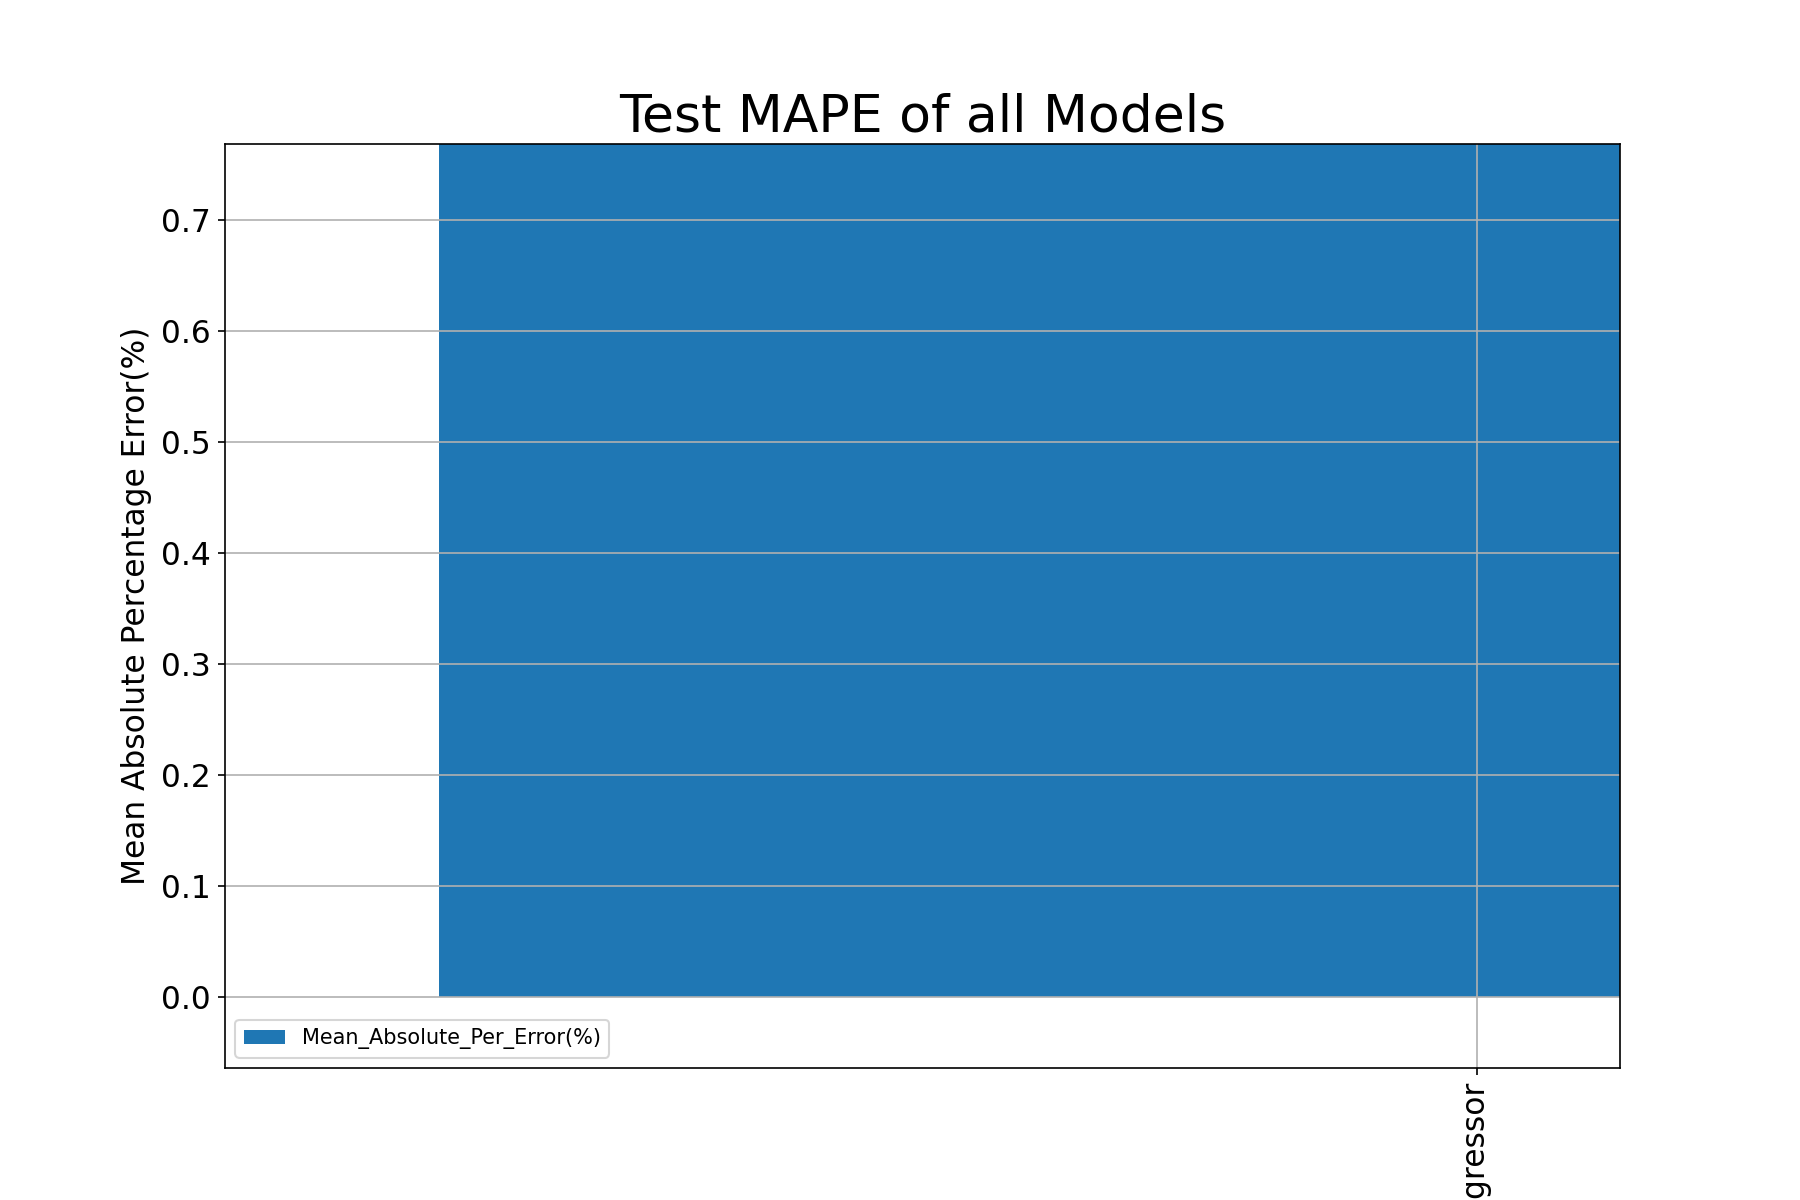

In [70]:
ax = Final_Table.plot(x = "Model", kind = "bar", figsize = (12, 8), grid = True, fontsize = 15)
ax.set_title("Test MAPE of all Models", fontsize = 25)
ax.set_ylabel("Mean Absolute Percentage Error(%)", fontsize = 15)

for i in ax.patches: 
    ax.text(i.get_x()-.05, i.get_height()+0.19, str(round(i.get_height(), 2))+'%', fontsize=14, color='black')

plt.show()